# Assignment: Explainable Techniques II

# Class: AIPI 590

# Author: Ramil Mammadov

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1dIloqeiSE6QZ6CnecURhhUACgiEj3QKV?usp=drive_link)







In [1]:
# Installing library
!pip install alibi -q

In [2]:
# Importing all libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from alibi.explainers import ALE
from alibi.explainers.ale import plot_ale
from google.colab import files
import io
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning,
                        message='.*X does not have valid feature names.*')

## Dataset

The dataset used in this analysis is the Bike Sharing Dataset, originally created by Fanaee-T, Hadi, and Gama, Joao (2013) and made available on the UCI Machine Learning Repository. The data was accessed for this project via the "Bike Sharing Demand" competition hosted on the Kaggle platform.

References:

Fanaee-T, Hadi, and Gama, Joao. "Event labeling combining ensemble detectors and background knowledge." Progress in Artificial Intelligence 2.1 (2013): 1-15.

Kaggle. "Bike Sharing Demand." Accessed September 27, 2025. https://www.kaggle.com/competitions/bike-sharing-demand/data?select=train.csv


## Model
The predictive model built for this assignment is a Gradient Boosting Regressor, implemented using the GradientBoostingRegressor class from the Scikit-learn library in Python.

In [3]:
# Uploading and Loading Data

df = pd.read_csv("/content/Bike sharing - train dataset.csv")
print(df.sample(10))

                  datetime  season  holiday  workingday  weather   temp  \
8862   2012-08-11 15:00:00       3        0           0        1  32.80   
6015   2012-02-06 21:00:00       1        0           1        1  13.12   
4751   2011-11-11 01:00:00       4        1           0        1  13.12   
10350  2012-11-16 16:00:00       4        0           1        1  17.22   
10261  2012-11-12 23:00:00       4        1           0        2  22.14   
2688   2011-06-19 22:00:00       2        0           0        1  27.06   
4656   2011-11-07 02:00:00       4        0           1        1  13.12   
3408   2011-08-11 22:00:00       3        0           1        1  28.70   
10304  2012-11-14 18:00:00       4        0           1        1  13.12   
4995   2011-12-02 05:00:00       4        0           1        1   9.02   

        atemp  humidity  windspeed  casual  registered  count  
8862   36.365        46    19.0012     246         316    562  
6015   15.910        57    11.0014      11    

In [4]:
# Feature Engineering

df['datetime'] = pd.to_datetime(df['datetime'])
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['dayofweek'] = df['datetime'].dt.dayofweek
df.drop('datetime', axis=1, inplace=True)
print(df.sample(10))

       season  holiday  workingday  weather   temp   atemp  humidity  \
5087        4        0           1        2  18.86  22.725        88   
8200        3        0           1        1  29.52  33.335        58   
9023        3        0           0        1  26.24  30.305        69   
912         1        0           1        1  13.94  15.150        53   
7024        2        0           1        1  13.94  15.150        36   
7995        2        0           1        2  27.88  31.820        44   
9199        3        0           1        1  30.34  34.850        70   
6471        1        0           1        1  13.12  15.910        49   
10573       4        0           1        1   9.84  12.120        65   
7313        2        0           1        1  23.78  27.275        83   

       windspeed  casual  registered  count  hour  month  year  dayofweek  
5087     19.9995       2          14     16     1     12  2011          1  
8200      0.0000       5           9     14     1      

## EDA

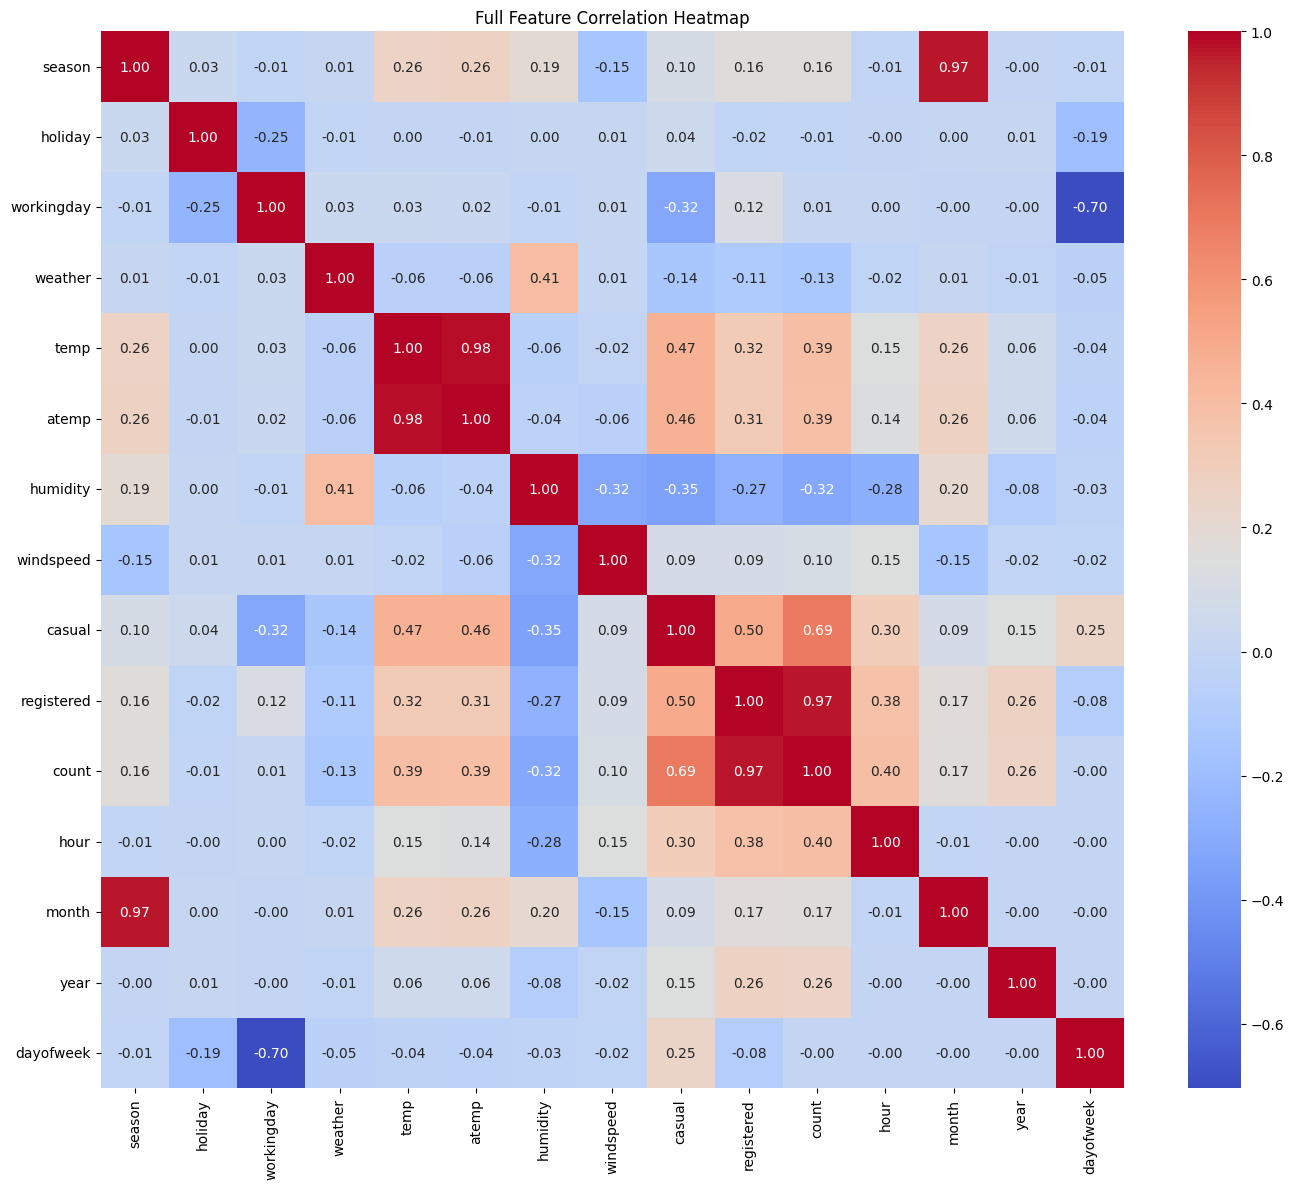

In [5]:
# Exploratory Data Analysis (Full Correlation Heatmap)

corr_matrix = df.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f",
            annot_kws={"size": 10})
plt.title('Full Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('full_correlation_heatmap.png')


### Exploratory Findings: Feature Correlation
The correlation heatmap provides the crucial context for this analysis. The most important finding is the extremely high positive correlation (0.98) between the temp (temperature) and atemp ("feels-like" temperature) features. This indicates that the two variables are nearly interchangeable and move in lockstep. This strong correlation has a significant impact on the interpretation plots, as we will see below.

Other logical correlations are also present:

 - The hour of the day has a moderate positive correlation with the rental count (0.40), reflecting commute patterns.

 - Humidity has a moderate negative correlation with count (-0.32), suggesting that less comfortable weather deters riders.

## Modeling

In [6]:
# Model Training

# Note: Even though we include them in the heatmap, we still drop 'casual' and
#'registered' from the feature set 'X' because they directly add up to the
#target 'y'.

features = [
    'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
    'humidity', 'windspeed', 'hour', 'month', 'year', 'dayofweek'
]
target = 'count'
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

print("Training Gradient Boosting model...")
gbr = GradientBoostingRegressor(n_estimators=100, max_depth=4,
                                learning_rate=0.1, random_state=42)
gbr.fit(X_train, y_train)
print("Model training complete.")

Training Gradient Boosting model...
Model training complete.


In [7]:
# Model Evaluation

y_pred = gbr.predict(X_test)

# Calculating the standard metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Calculating normalized RMSE for better context
average_rentals = y_test.mean()
normalized_rmse = rmse / average_rentals

print(f"R-squared (R²): {r2:.4f} (Proportion of variance explained)")
print(f"Mean Absolute Error (MAE): {mae:.2f} bikes (Average raw error)")
print(f"""Root Mean Squared Error (RMSE): {rmse:.2f} bikes (Error penalized for
large mistakes)""")
print(f"""Normalized RMSE: {normalized_rmse:.2%} (Error as a percentage of
the average value)""")

R-squared (R²): 0.9169 (Proportion of variance explained)
Mean Absolute Error (MAE): 34.26 bikes (Average raw error)
Root Mean Squared Error (RMSE): 52.37 bikes (Error penalized for 
large mistakes)
Normalized RMSE: 27.34% (Error as a percentage of 
the average value)


## PDP & ICE Plots

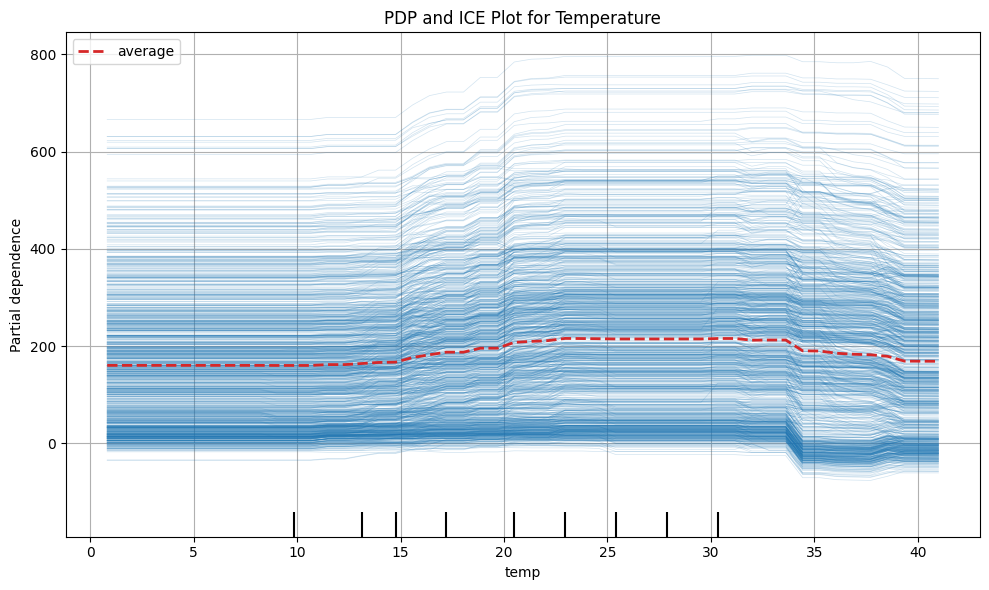

In [8]:
# Generating PDP and ICE Plots

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    gbr,
    X_train,
    features=['temp'],
    kind='both',
    ax=ax,
    ice_lines_kw={"color": "tab:blue", "alpha": 0.2, "linewidth": 0.5},
    pd_line_kw={"color": "tab:red", "linewidth": 2, "linestyle": "--"}
)
ax.set_title('PDP and ICE Plot for Temperature')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Predicted Bike Count')
plt.grid(True)
plt.tight_layout()
# plt.savefig('pdp_ice_plot.png')

### PDP/ICE Plot for Temperature
This plot visualizes the model's learned relationship between temperature and bike rentals.

 - The Average Trend (PDP): The bold red dashed line shows the average predicted bike count increases steadily as the temperature rises. It suggests a simple, almost linear positive relationship: hotter weather leads to more rentals, on average.

 - The Individual Trends (ICE): The thin blue lines reveal a more complex story. While they generally follow the upward trend of the PDP, their different slopes indicate the presence of interaction effects. This means the effect of temperature isn't uniform; its impact is stronger on some days (steeper lines) and weaker on others (flatter lines), depending on other factors like the weather or day of the week.

## ALE Plot

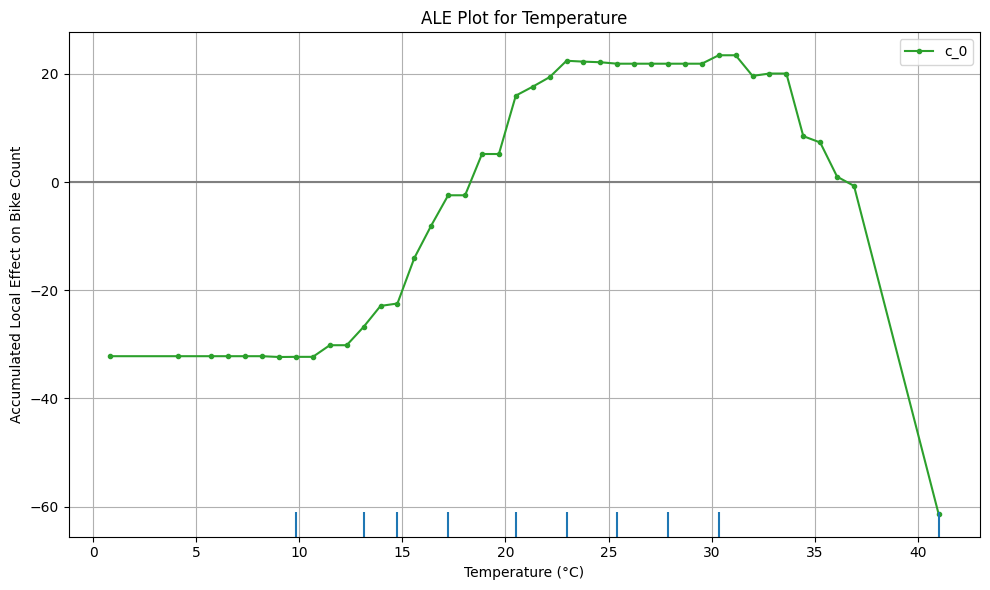

In [9]:
# Generating ALE Plot

predict_fn = lambda x: gbr.predict(x)
ale_explainer = ALE(predict_fn, feature_names=features)
exp = ale_explainer.explain(X_train.to_numpy())

fig, ax = plt.subplots(figsize=(10, 6))
plot_ale(exp, features=['temp'], ax=ax, line_kw={"color": "tab:green"})
ax.set_title('ALE Plot for Temperature')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Accumulated Local Effect on Bike Count')
plt.grid(True)
plt.tight_layout()
# plt.savefig('ale_plot.png')

### ALE Plot for Temperature
This plot shows the same relationship but corrects for the influence of correlated features like atemp.

Interesting Findings: The key finding here is that the relationship is highly non-linear.

 - Below 12°C (Cold Zone): The effect is consistently negative and flat. Cold is simply bad for rentals.

 - 12°C to 23°C (Optimal Zone): The curve rises sharply. In this comfortable range, every degree increase has a strong positive impact.

 - 23°C to 32°C (Warm Zone): The curve's slope is relatively stable. Higher temperatures still help, but not as much.

 - 32°C to 37°C (Hot Zone): The effect is going down, resulting in a decrease in the number of renters.

 - Above 37°C (Too Hot Zone): The curve flattens completely, indicating that extreme heat provides no additional benefit and may even deter riders.

### Conclusion
This is the central conclusion of my analysis.

 - The Difference: The PDP presents the relationship as a simple, near-linear increase. In contrast, the ALE plot reveals a more nuanced, S-shaped curve with clear diminishing returns at higher temperatures.

 - The Impact of Correlation: The reason for this difference is the 0.98 correlation between temp and atemp.

 - The PDP is misleading because its algorithm creates unrealistic data points. To calculate the effect of temp, it artificially changes its value while holding atemp constant, leading to nonsensical combinations (e.g., a 35°C day that "feels like" 15°C). The model's predictions on these "fake" data points are averaged in, which smooths out the true relationship and hides the diminishing returns.

 - The ALE plot is more accurate because it avoids this problem. It calculates the effect of temperature in small, localized windows using only realistic data combinations that exist in the dataset. This neutralizes the confounding effect of the correlated atemp feature, revealing the model's true, non-linear understanding of temperature's impact.

## LLM
For this assignment, Google's Gemini 2.5 Pro large language model was utilized to generate some of the Python code for the modeling, evaluation, and visualization steps. The tool was also used for correcting and adjusting markdown formatting.